In [37]:
import os
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import soundfile as sf
from pydub import AudioSegment, effects
from tqdm import tqdm

In [38]:
# Configuration
INPUT_ROOT = '/home/dl/G11/dataset/processed_dataset'  # Path to original dataset
PROCESSED_ROOT = '/home/dl/G11/dataset/preprocessed_dataset'  # Where processed WAVs will be saved
SAMPLE_RATE = 16000  # Target sample rate
AUGMENT = True  # Set to False for validation/testing

In [39]:
# Create output directory
os.makedirs(PROCESSED_ROOT, exist_ok=True)

In [40]:
def convert_and_preprocess_audio(input_path, output_path, target_sr=16000):
    audio = AudioSegment.from_file(input_path)

    # Trim silence
    audio = effects.strip_silence(audio, silence_thresh=-50.0, padding=100)

    # Normalize
    audio = effects.normalize(audio)

    # Resample
    audio = audio.set_frame_rate(target_sr)

    # Export as .mp3
    audio.export(output_path, format="mp3")

In [34]:
def preprocess_audio(file_path, sr=SAMPLE_RATE, augment=False):
    try:
        y, _ = librosa.load(file_path, sr=sr, mono=True)

        # Trim silence
        y, _ = librosa.effects.trim(y)

        # Normalize volume
        y = y / np.max(np.abs(y) + 1e-6)  # Avoid divide-by-zero

        if augment:
            # Add noise
            noise = np.random.randn(len(y)) * 0.005
            y += noise

            # Time-stretch (works on waveform y)
            rate = np.random.uniform(0.9, 1.1)
            y = librosa.effects.time_stretch(y, rate=rate)

        # Mel-Spectrogram
        mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
        mel_db = librosa.power_to_db(mel, ref=np.max)
        return mel_db

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return np.zeros((128, 100), dtype=np.float32)


In [41]:
def load_dataset(input_root, processed_root, augment=False):
    X = []
    y = []

    os.makedirs(processed_root, exist_ok=True)

    for file_name in tqdm(os.listdir(input_root), desc="Processing audio files"):
        if file_name.endswith(".mp3"):
            label = file_name.split("_")[0]
            input_path = os.path.join(input_root, file_name)
            output_path = os.path.join(processed_root, file_name)

            try:
                # Convert and preprocess
                convert_and_preprocess_audio(input_path, output_path)

                # Extract mel spectrogram
                mel_spec = preprocess_audio(output_path, augment=augment)

                if mel_spec is None or np.sum(mel_spec) == 0:
                    raise ValueError("Invalid mel spectrogram")

                X.append(mel_spec)
                y.append(label)

            except Exception as e:
                print(f"Error processing {input_path}: {e}")

                # Attempt to delete input file
                try:
                    os.remove(input_path)
                    print(f"Deleted corrupted input file: {input_path}")
                except Exception as delete_error:
                    print(f"Failed to delete input file: {delete_error}")

                # Attempt to delete processed output file
                try:
                    if os.path.exists(output_path):
                        os.remove(output_path)
                        print(f"Deleted corrupted output file: {output_path}")
                except Exception as delete_error:
                    print(f"Failed to delete output file: {delete_error}")

    return X, y


In [42]:
# === Run the full pipeline ===
X_data, y_labels = load_dataset(INPUT_ROOT, PROCESSED_ROOT, augment=AUGMENT)
print(f"Total samples loaded: {len(X_data)}")

Processing audio files:  56%|█████▋    | 565/1000 [05:33<04:09,  1.74it/s]/tmp/ipykernel_398089/3118940186.py:3: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(file_path, sr=sr, mono=True)
[src/libmpg123/parse.c:do_readahead():1123] warning: Cannot read next header, a one-frame stream? Duh...
/home/dl/.conda/envs/audioenv/lib/python3.9/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Processing audio files:  57%|█████▋    | 566/1000 [05:34<04:08,  1.74it/s]

Error processing /home/dl/G11/dataset/preprocessed_dataset/Hindi_10072.mp3: 
Error processing /home/dl/G11/dataset/processed_dataset/Hindi_10072.mp3: Invalid mel spectrogram
Deleted corrupted input file: /home/dl/G11/dataset/processed_dataset/Hindi_10072.mp3
Deleted corrupted output file: /home/dl/G11/dataset/preprocessed_dataset/Hindi_10072.mp3


Processing audio files:  60%|█████▉    | 598/1000 [05:52<03:36,  1.86it/s]/tmp/ipykernel_398089/3118940186.py:3: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(file_path, sr=sr, mono=True)
[src/libmpg123/parse.c:do_readahead():1123] warning: Cannot read next header, a one-frame stream? Duh...
/home/dl/.conda/envs/audioenv/lib/python3.9/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Processing audio files:  60%|█████▉    | 599/1000 [05:52<02:59,  2.24it/s]

Error processing /home/dl/G11/dataset/preprocessed_dataset/Malayalam_10039.mp3: 
Error processing /home/dl/G11/dataset/processed_dataset/Malayalam_10039.mp3: Invalid mel spectrogram
Deleted corrupted input file: /home/dl/G11/dataset/processed_dataset/Malayalam_10039.mp3
Deleted corrupted output file: /home/dl/G11/dataset/preprocessed_dataset/Malayalam_10039.mp3


Processing audio files:  65%|██████▌   | 651/1000 [06:22<03:21,  1.73it/s]/tmp/ipykernel_398089/3118940186.py:3: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(file_path, sr=sr, mono=True)
/home/dl/.conda/envs/audioenv/lib/python3.9/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
[src/libmpg123/parse.c:do_readahead():1123] warning: Cannot read next header, a one-frame stream? Duh...
Processing audio files:  65%|██████▌   | 652/1000 [06:22<03:18,  1.76it/s]

Error processing /home/dl/G11/dataset/preprocessed_dataset/Marathi_10058.mp3: 
Error processing /home/dl/G11/dataset/processed_dataset/Marathi_10058.mp3: Invalid mel spectrogram
Deleted corrupted input file: /home/dl/G11/dataset/processed_dataset/Marathi_10058.mp3
Deleted corrupted output file: /home/dl/G11/dataset/preprocessed_dataset/Marathi_10058.mp3


Processing audio files:  66%|██████▌   | 658/1000 [06:25<03:12,  1.78it/s]/tmp/ipykernel_398089/3118940186.py:3: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(file_path, sr=sr, mono=True)
/home/dl/.conda/envs/audioenv/lib/python3.9/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
[src/libmpg123/parse.c:do_readahead():1123] warning: Cannot read next header, a one-frame stream? Duh...
Processing audio files:  66%|██████▌   | 659/1000 [06:26<03:14,  1.75it/s]

Error processing /home/dl/G11/dataset/preprocessed_dataset/Hindi_10069.mp3: 
Error processing /home/dl/G11/dataset/processed_dataset/Hindi_10069.mp3: Invalid mel spectrogram
Deleted corrupted input file: /home/dl/G11/dataset/processed_dataset/Hindi_10069.mp3
Deleted corrupted output file: /home/dl/G11/dataset/preprocessed_dataset/Hindi_10069.mp3


Processing audio files: 100%|██████████| 1000/1000 [09:39<00:00,  1.73it/s]

Total samples loaded: 996


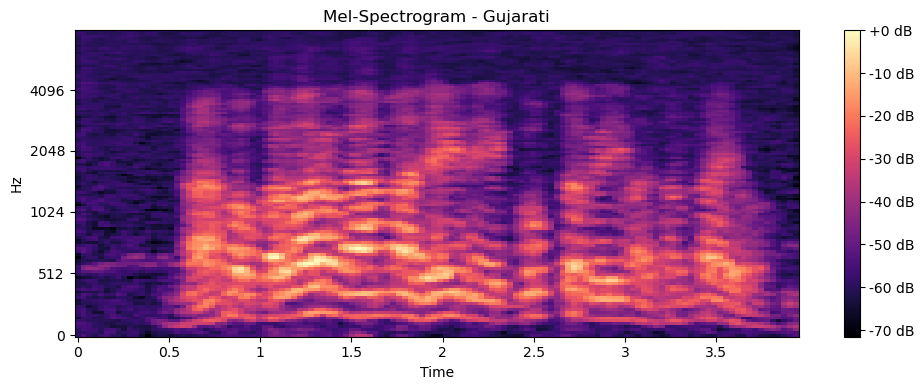

In [43]:
# === Optional: Visualize first spectrogram ===
if X_data:
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(X_data[0], sr=SAMPLE_RATE, x_axis='time', y_axis='mel')
    plt.title(f'Mel-Spectrogram - {y_labels[0]}')
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.show()